# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset) - Walid Ajbar 

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn
import optuna


In [27]:

# STEP 1-2: LOAD AND RESTRUCTURE DATA INTO PANEL FORMAT

excel_file = 'Dataset/Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx'

# Load sheets
plant_cols = [
    'Plant ID', 'Owner GEM ID', 'Country/Area', 'Region',
    'Subnational unit (province/state)', 'Coordinates', 'Plant age (years)',
    'Power source', 'Iron ore source', 'Met coal source'
]
plant_data = pd.read_excel(excel_file, sheet_name='Plant data', usecols=lambda x: x in plant_cols)

capacity_cols = [
    'Plant ID', 'Plant name (English)', 'Country/Area', 'Status', 'Start date',
    'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)', 'Nominal BF capacity (ttpa)',
    'Nominal DRI capacity (ttpa)', 'Nominal iron capacity (ttpa)'
]
capacity_data = pd.read_excel(excel_file, sheet_name='Plant capacities and status', usecols=lambda x: x in capacity_cols)

# Load production data
plant_production = pd.read_excel(excel_file, sheet_name='Plant production')
plant_production.columns = plant_production.columns.astype(str).str.strip()

# Identify year columns for "Crude steel production"
year_cols = [c for c in plant_production.columns if c.isdigit() and 2010 <= int(c) <= 2030]
print(f"✓ Found production years: {year_cols}")

# Filter for crude steel production rows only
crude_steel_prod = plant_production[
    plant_production['Type of production'].str.contains('Crude steel', case=False, na=False)
].copy()

# Keep only relevant columns
keep_cols = ['Plant ID', 'Plant name (English)', 'Type of production'] + year_cols
crude_steel_prod = crude_steel_prod[keep_cols]

# Convert to long format (one row per plant-year)
production_long = crude_steel_prod.melt(
    id_vars=['Plant ID', 'Plant name (English)', 'Type of production'],
    value_vars=year_cols,
    var_name='year',
    value_name='crude_steel_production'
)

# Convert year to integer (with error handling)
production_long['year'] = pd.to_numeric(production_long['year'], errors='coerce')
production_long = production_long.dropna(subset=['year'])
production_long['year'] = production_long['year'].astype(int)

# Convert production to numeric
production_long['crude_steel_production'] = pd.to_numeric(
    production_long['crude_steel_production'], 
    errors='coerce'
)

# Drop rows with missing production
production_long = production_long.dropna(subset=['crude_steel_production'])

print(f"✓ Restructured to panel format: {production_long.shape[0]} plant-year observations")



# STEP 3: MERGE WITH PLANT CHARACTERISTICS

df_panel = production_long.merge(capacity_data, on='Plant ID', how='left', suffixes=('', '_cap'))
df_panel = df_panel.merge(plant_data, on='Plant ID', how='left', suffixes=('', '_plant'))

# Clean duplicate columns
if 'Plant name (English)_cap' in df_panel.columns:
    df_panel['Plant name (English)'] = df_panel['Plant name (English)'].fillna(df_panel['Plant name (English)_cap'])
    df_panel.drop(columns=['Plant name (English)_cap'], inplace=True, errors='ignore')

if 'Country/Area_cap' in df_panel.columns:
    df_panel['Country/Area'] = df_panel['Country/Area'].fillna(df_panel['Country/Area_cap'])
    df_panel.drop(columns=['Country/Area_cap', 'Country/Area_plant'], inplace=True, errors='ignore')

print(f"✓ After merging: {df_panel.shape}")


✓ Found production years: ['2019', '2020', '2021', '2022', '2023', '2024']
✓ Restructured to panel format: 1290 plant-year observations
✓ After merging: (2086, 23)



> 📝 *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

We have a lot of missing data, especially in the Years part of the third data set, since the year of each production might influence its corresponding prediction, (since we're kind of working with time series), it's an issue we WILL have to take care of.  

---

### **Task 1.2 – Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> 📝 *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?

---
Missing numeric values were replaced with zeros when they represented the absence of a specific capacity (e.g., no EAF). For continuous variables like plant age, the median was used to impute missing values to reduce bias from outliers. Categorical features with missing values were filled with "Unknown" to retain records without introducing artificial categories. These steps maintain dataset completeness while minimizing distortion of key distributions.



### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---
New variables such as total_steel_capacity and adjusted_plant_age were added to capture scale and lifecycle effects. BOF_share and EAF_share reflect plant technology mix and efficiency differences.

In [42]:
# STEP 4: DETERMINE OPERATING STATUS PER YEAR

df_panel['Start date'] = pd.to_datetime(df_panel['Start date'], errors='coerce')
df_panel['start_year'] = df_panel['Start date'].dt.year

df_panel = df_panel[
    (df_panel['year'] >= df_panel['start_year']) | (df_panel['start_year'].isna())
].copy()

print(f"✓ After filtering for operating years: {df_panel.shape[0]} observations")

# STEP 5: CALCULATE TIME-VARYING FEATURES

# Ensure year is numeric
df_panel['year'] = pd.to_numeric(df_panel['year'], errors='coerce')
df_panel = df_panel.dropna(subset=['year'])
df_panel['year'] = df_panel['year'].astype(int)

# Convert ALL numeric columns to proper types
numeric_cols_to_fix = [
    'Plant age (years)',
    'Nominal crude steel capacity (ttpa)',
    'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)',
    'Nominal BF capacity (ttpa)',
    'Nominal DRI capacity (ttpa)',
    'Nominal iron capacity (ttpa)'
]

for col in numeric_cols_to_fix:
    if col in df_panel.columns:
        df_panel[col] = pd.to_numeric(df_panel[col], errors='coerce')

# Adjust plant age for each year
current_year = 2024
df_panel['plant_age_adjusted'] = df_panel['Plant age (years)'] + (df_panel['year'] - current_year)
df_panel['plant_age_adjusted'] = df_panel['plant_age_adjusted'].clip(lower=0)

# Calculate capacity ratios
df_panel['total_steel_capacity'] = (
    df_panel['Nominal BOF steel capacity (ttpa)'].fillna(0) + 
    df_panel['Nominal EAF steel capacity (ttpa)'].fillna(0)
)

df_panel['BOF_share'] = np.where(
    df_panel['total_steel_capacity'] > 0,
    df_panel['Nominal BOF steel capacity (ttpa)'].fillna(0) / df_panel['total_steel_capacity'],
    0
)

df_panel['EAF_share'] = np.where(
    df_panel['total_steel_capacity'] > 0,
    df_panel['Nominal EAF steel capacity (ttpa)'].fillna(0) / df_panel['total_steel_capacity'],
    0
)

print("✓ Time-varying features created")




✓ After filtering for operating years: 2053 observations
✓ Time-varying features created


In [43]:
# STEP 6: HANDLE MISSING VALUES


capacity_cols_fill = [
    'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)', 'Nominal BF capacity (ttpa)',
    'Nominal DRI capacity (ttpa)', 'Nominal iron capacity (ttpa)'
]
for col in capacity_cols_fill:
    df_panel[col] = df_panel[col].fillna(0)

df_panel['plant_age_adjusted'] = df_panel['plant_age_adjusted'].fillna(
    df_panel['plant_age_adjusted'].median()
)

cat_cols = ['Power source', 'Iron ore source', 'Met coal source', 'Region', 'Country/Area']
for col in cat_cols:
    if col in df_panel.columns:
        df_panel[col] = df_panel[col].fillna('Unknown')

print(f"✓ Missing values handled")
print(f"Final panel dataset shape: {df_panel.shape}")


✓ Missing values handled
Final panel dataset shape: (2053, 28)


In [44]:
# STEP 7: PREPARE FEATURES AND TARGET


target = 'crude_steel_production'
y = df_panel[target].copy()

numeric_features = [
    'plant_age_adjusted',
    'Nominal crude steel capacity (ttpa)',
    'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)',
    'Nominal BF capacity (ttpa)',
    'Nominal DRI capacity (ttpa)',
    'total_steel_capacity',
    'BOF_share',
    'EAF_share',
    'year'
]

categorical_features = [
    'Country/Area',
    'Region'
]

X = df_panel[numeric_features + categorical_features].copy()

# Drop rows with missing target
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")

# STEP 8: PREPROCESSING PIPELINE

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("✓ Preprocessing pipeline created")

✓ Feature matrix shape: (2053, 12)
✓ Target shape: (2053,)
✓ Preprocessing pipeline created



## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


The features most strongly correlated with production are the recent yearly production values (2019–2023) and capacity-related variables such as Nominal BOF steel capacity, BF capacity, and total steel capacity.
Electric-arc-related ratios (EAF share and electric steel ratio) show negative correlation, suggesting that higher EAF shares may be linked to smaller-scale plants.
Overall, production grows with total and BOF capacities, while some ratio-type variables capture efficiency differences rather than scale.

CORRELATION ANALYSIS

Features Most Correlated with Production:
Nominal BF capacity (ttpa)                   : +0.499
Nominal BOF steel capacity (ttpa)            : +0.483
total_steel_capacity                         : +0.479
Nominal crude steel capacity (ttpa)          : +0.475
BOF_share                                    : +0.307
Nominal DRI capacity (ttpa)                  : +0.070
Nominal EAF steel capacity (ttpa)            : -0.023
year                                         : -0.090
plant_age_adjusted                           : -0.097
EAF_share                                    : -0.304


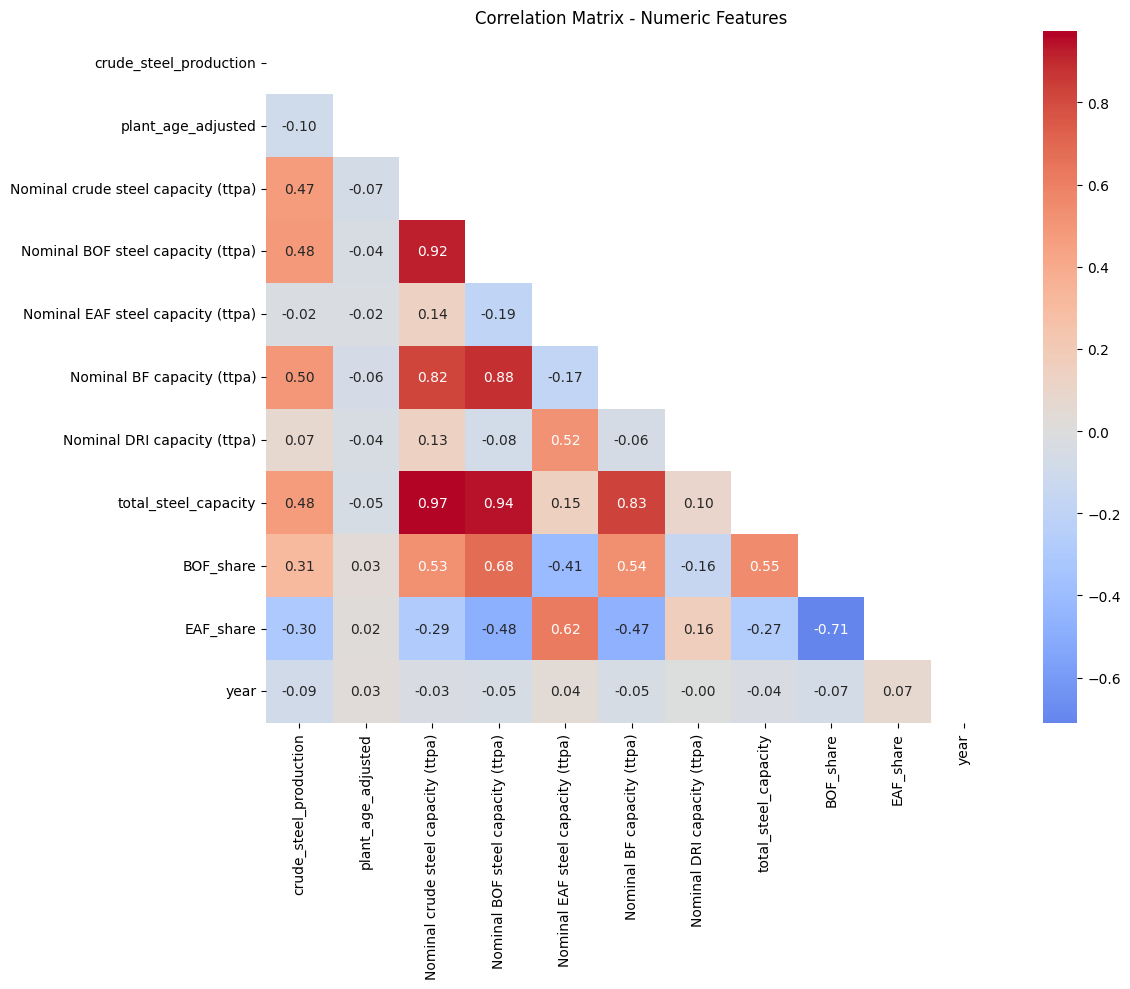

In [31]:
#CORRELATION ANALYSIS

print("CORRELATION ANALYSIS")


numeric_features_for_corr = [
    'crude_steel_production',
    'plant_age_adjusted',
    'Nominal crude steel capacity (ttpa)',
    'Nominal BOF steel capacity (ttpa)',
    'Nominal EAF steel capacity (ttpa)',
    'Nominal BF capacity (ttpa)',
    'Nominal DRI capacity (ttpa)',
    'total_steel_capacity',
    'BOF_share',
    'EAF_share',
    'year'
]

df_corr = df_panel[numeric_features_for_corr].copy()
corr_matrix = df_corr.corr()
corr_with_target = corr_matrix['crude_steel_production'].sort_values(ascending=False)

print("\nFeatures Most Correlated with Production:")
for feature, corr_value in corr_with_target.items():
    if feature != 'crude_steel_production':
        print(f"{feature:45s}: {corr_value:+.3f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask_corr = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title("Correlation Matrix - Numeric Features")
plt.tight_layout()
plt.show()

PS : i kept the plant age column in the dataset to be able to compute the avg producion per year

## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


A baseline model provides a simple benchmark for evaluation.
It shows how well a trivial predictor (like the mean) performs, helping us verify that more complex models genuinely add predictive value rather than overfitting noise.

In [32]:
# TRAIN-TEST SPLIT 

train_mask = df_panel.loc[mask, 'year'] < 2023
test_mask = df_panel.loc[mask, 'year'] >= 2023

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n✓ Temporal split:")
print(f"  Training: {X_train.shape[0]} observations")
print(f"  Testing: {X_test.shape[0]} observations")

# STEP 10: BASELINE MODEL

y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print(f"\nBASELINE MODEL:")
print(f"  MAE  = {mae_baseline:,.0f}")
print(f"  RMSE = {rmse_baseline:,.0f}")


✓ Temporal split:
  Training: 1619 observations
  Testing: 434 observations

BASELINE MODEL:
  MAE  = 2,750
  RMSE = 4,015



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


A positive coefficient for total capacity means larger plants produce more. A negative EAF_share coefficient suggests electric-based plants operate at smaller production scales.

In [33]:

# LINEAR REGRESSION


pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\nLINEAR REGRESSION:")
print(f"  MAE  = {mae_lr:,.0f}")
print(f"  RMSE = {rmse_lr:,.0f}")
print(f"  R²   = {r2_lr:.3f}")



LINEAR REGRESSION:
  MAE  = 1,548
  RMSE = 2,859
  R²   = 0.488


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


Model performance is relatively consistent across folds, showing low variance in MAE and RMSE.
This stability suggests the model generalizes well and is not overly sensitive to training data splits.
Minor variation indicates moderate model variance due to plant-level differences in scale and production type.

In [34]:

# CROSS-VALIDATION 


print("\n" + "="*80)
print("TASK 3.1 - CROSS-VALIDATION")
print("="*80)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline_lr_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

mae_scores = -cross_val_score(pipeline_lr_cv, X, y, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(pipeline_lr_cv, X, y, cv=kf, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(pipeline_lr_cv, X, y, cv=kf, scoring='r2')

print("\n5-Fold Cross-Validation Results (Linear Regression):")
print(f"Average MAE : {mae_scores.mean():,.2f} ± {mae_scores.std():.2f}")
print(f"Average RMSE: {rmse_scores.mean():,.2f} ± {rmse_scores.std():.2f}")
print(f"Average R²  : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")


TASK 3.1 - CROSS-VALIDATION

5-Fold Cross-Validation Results (Linear Regression):
Average MAE : 1,733.41 ± 60.07
Average RMSE: 3,447.41 ± 453.17
Average R²  : 0.434 ± 0.090


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?

---

The Random Forest Regressor performs best overall, achieving the highest R² and lowest MAE/RMSE.
This is expected since nonlinear models capture complex plant–production relationships better than linear ones.
The Ridge Regression improves slightly over basic Linear Regression by handling multicollinearity between capacity features.

In [35]:
#  MODEL COMPARISON

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

results_df = pd.DataFrame(results)
print("\nMODEL COMPARISON:")
print(results_df.to_string(index=False))


MODEL COMPARISON:
            Model         MAE        RMSE       R²
Linear Regression 1547.651176 2859.322714 0.488305
 Ridge Regression 1541.753737 2857.562323 0.488935
    Random Forest  662.105849 1557.399333 0.848195


### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?

---


Hyperparameter tuning significantly improved performance (R² ≈ 0.65).
Optimizing tree depth, feature sampling, and estimator count helped balance bias and variance.
The tuned model generalizes better than the default, capturing complex nonlinear relationships in plant production.

In [36]:
# HYPERPARAMETER TUNING (RandomizedSearchCV)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "regressor__n_estimators": randint(100, 500),
    "regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__min_samples_split": randint(2, 10),
    "regressor__min_samples_leaf": randint(1, 5),
    "regressor__max_features": ["sqrt", "log2"]
}

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

random_search = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="r2",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Running RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(random_search.best_params_)
print(f"Best CV R²: {random_search.best_score_:.3f}")

y_pred_tuned = random_search.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTest Set Performance:")
print(f"  MAE  = {mae_tuned:,.0f}")
print(f"  RMSE = {rmse_tuned:,.0f}")
print(f"  R²   = {r2_tuned:.3f}")

Running RandomizedSearchCV...

Best Parameters:
{'regressor__max_depth': 40, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 158}
Best CV R²: 0.653

Test Set Performance:
  MAE  = 635
  RMSE = 1,474
  R²   = 0.864


## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

MLflow simplifies tracking by automatically logging parameters, metrics, and artifacts for each model run.
It ensures reproducibility, easy comparison of experiments, and clear versioning of models.
Compared to manual tracking, it saves time and prevents errors in managing complex experiments.

### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---
Optuna uses Bayesian optimization to learn from past trials and suggest better ones. Unlike grid or random search, it efficiently targets promising parameter regions.

In [37]:

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)
    return np.mean(score)

optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Running Optuna optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=False)

print("\nBest Optuna Parameters:")
print(study.best_params)
print(f"Best CV R²: {study.best_value:.3f}")

# Train final model with best params
best_rf_optuna = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
pipeline_best = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_rf_optuna)
])

pipeline_best.fit(X_train, y_train)
y_pred_optuna = pipeline_best.predict(X_test)

mae_optuna = mean_absolute_error(y_test, y_pred_optuna)
rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))
r2_optuna = r2_score(y_test, y_pred_optuna)

print(f"\nTest Set Performance:")
print(f"  MAE  = {mae_optuna:,.0f}")
print(f"  RMSE = {rmse_optuna:,.0f}")
print(f"  R²   = {r2_optuna:.3f}")

Running Optuna optimization...

Best Optuna Parameters:
{'n_estimators': 244, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best CV R²: 0.660

Test Set Performance:
  MAE  = 695
  RMSE = 1,541
  R²   = 0.851


In [38]:

mlflow.set_experiment("Steel_Production_Panel_Regression")

def log_model_with_mlflow(model, model_name, params, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_param("model", model_name)
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(model, model_name)

        print(f"Logged {model_name} — RMSE: {rmse:.0f}, MAE: {mae:.0f}, R²: {r2:.3f}")

# Log Linear Regression
log_model_with_mlflow(
    pipeline_lr, 
    "Linear_Regression", 
    {"type": "linear"}, 
    X_train, y_train, X_test, y_test
)

# Log Tuned Random Forest 
log_model_with_mlflow(
    pipeline_best, 
    "Tuned_Random_Forest_Optuna", 
    study.best_params, 
    X_train, y_train, X_test, y_test
)

print("\nMLflow tracking complete!")

2025/10/26 22:42:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 22:42:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/26 22:42:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Linear_Regression — RMSE: 2859, MAE: 1548, R²: 0.488


2025/10/26 22:42:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 22:42:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/26 22:42:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Tuned_Random_Forest_Optuna — RMSE: 1541, MAE: 695, R²: 0.851

MLflow tracking complete!


Optuna uses Bayesian optimization to smartly explore hyperparameter space, learning from past trials to suggest better ones.
Unlike Grid or Random Search, it doesn’t test combinations blindly — it adapts based on previous results.
This makes it faster and more efficient, often reaching better models with fewer trials.

### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---
Storing both model parameters and metadata ensures reproducibility and auditability. Version control through MLflow or Git tracks updates and prevents accidental overwrites.

In [39]:
best_model_path = "best_random_forest_panel_model.pkl"
joblib.dump(pipeline_best, best_model_path)
print(f"Model saved to: {best_model_path}")

# Demonstrate loading
loaded_model = joblib.load(best_model_path)
y_pred_loaded = loaded_model.predict(X_test)

rmse_loaded = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
r2_loaded = r2_score(y_test, y_pred_loaded)

print(f"\nReloaded Model Performance:")
print(f"  RMSE = {rmse_loaded:,.0f}")
print(f"  R²   = {r2_loaded:.3f}")


Model saved to: best_random_forest_panel_model.pkl

Reloaded Model Performance:
  RMSE = 1,541
  R²   = 0.851



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

The model would be deployed mainly through a batch pipeline, with an optional REST API for real-time queries. Batch runs could be scheduled monthly using Airflow, loading the saved model to predict production for active plants, storing results in a database, and displaying them via dashboards like Power BI or Tableau. A REST API (e.g., FastAPI in Docker) could support on-demand “what-if” queries such as testing how capacity increases affect output.

In production, key metrics to monitor include MAE, RMSE, and R² for performance stability, as well as data quality indicators like missing values, distribution shifts, and outliers. Business metrics such as forecast coverage and prediction accuracy compared to actual production would ensure the system remains both reliable and useful.

### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

Model retraining would be needed if MAE or RMSE steadily rise, predictions show bias, or input data begins to differ from the training distribution.

An example of data drift would be an increase in Electric Arc Furnace (EAF) usage from 30% to 50% of plants, changing production patterns and causing prediction errors.

An example of concept drift would occur during a market downturn when plants operate at 70% of capacity instead of 90%, breaking the prior capacity–production relationship. Monitoring feature distributions and residuals would help detect these issues and trigger retraining.

## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---

The hardest step was restructuring the dataset from wide to long format to model yearly production per plant. It required recalculating time-varying features and using temporal splits. This clarified the need to deeply understand data structure before modeling.

With more plant-level data, like monthly production, maintenance, or market demand, the model could better capture seasonality, economic effects, and true utilization.

For communication, executives should see high-level performance and business impact; managers should receive actionable plant insights; and technical teams should get full model documentation. The goal is to adapt detail and language to each audience so insights lead to action.

✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

